In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams["font.family"] = "FreeSans"

In [3]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing

In [4]:
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [5]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

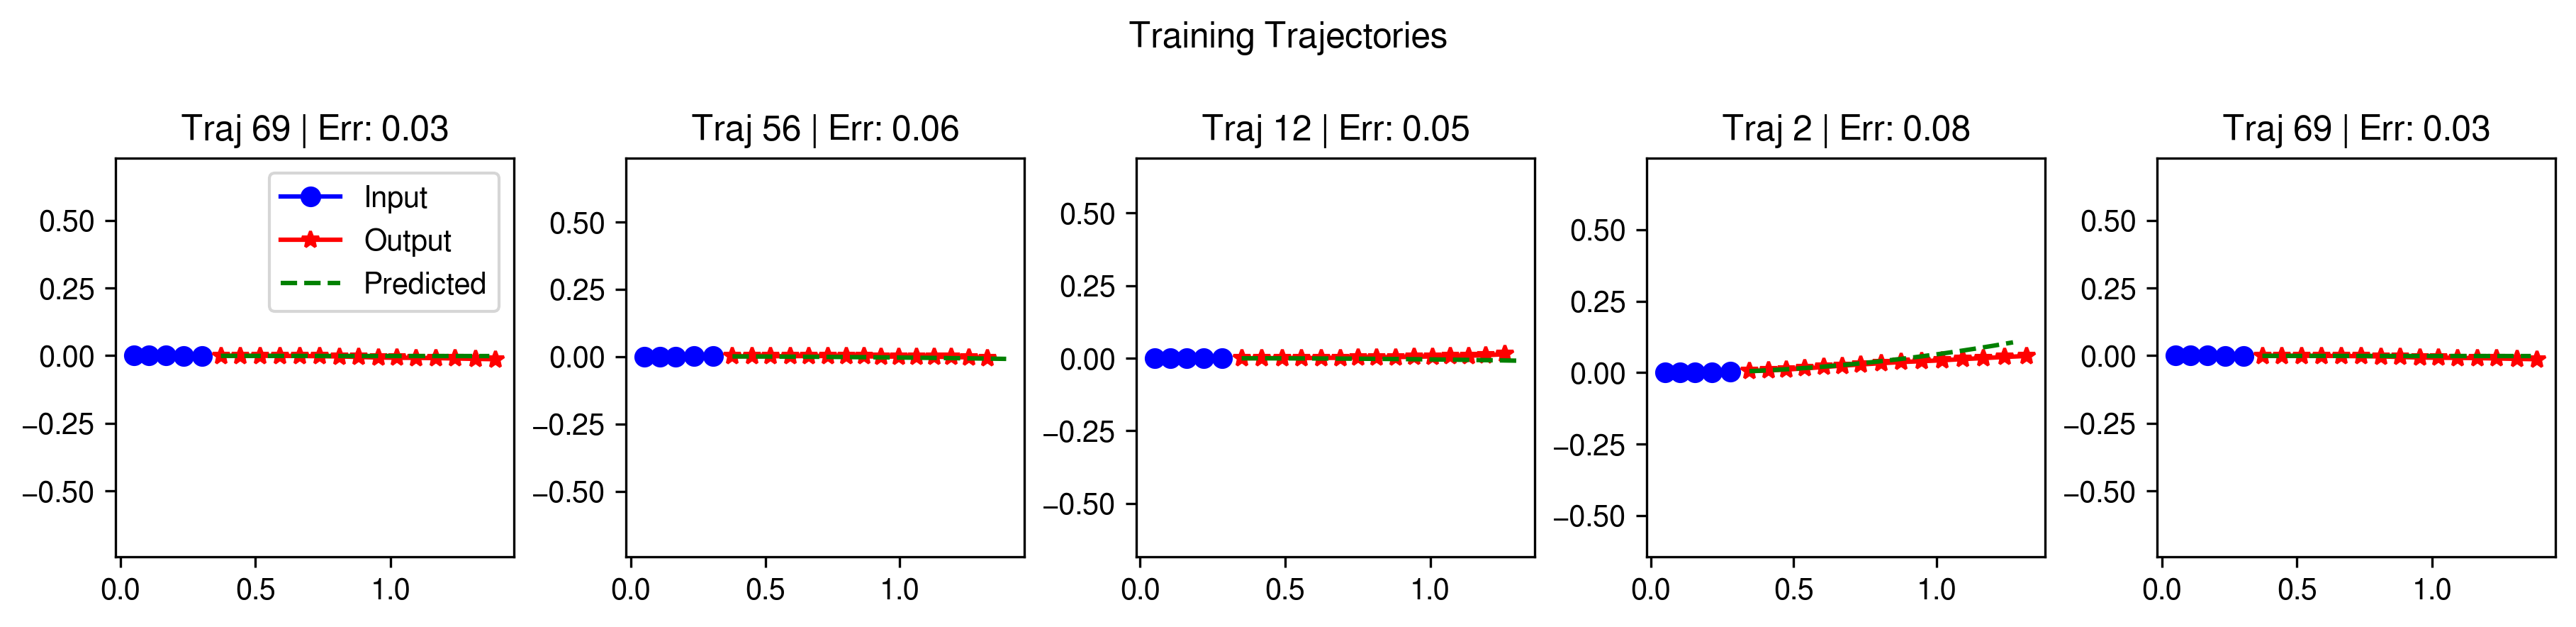

In [6]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

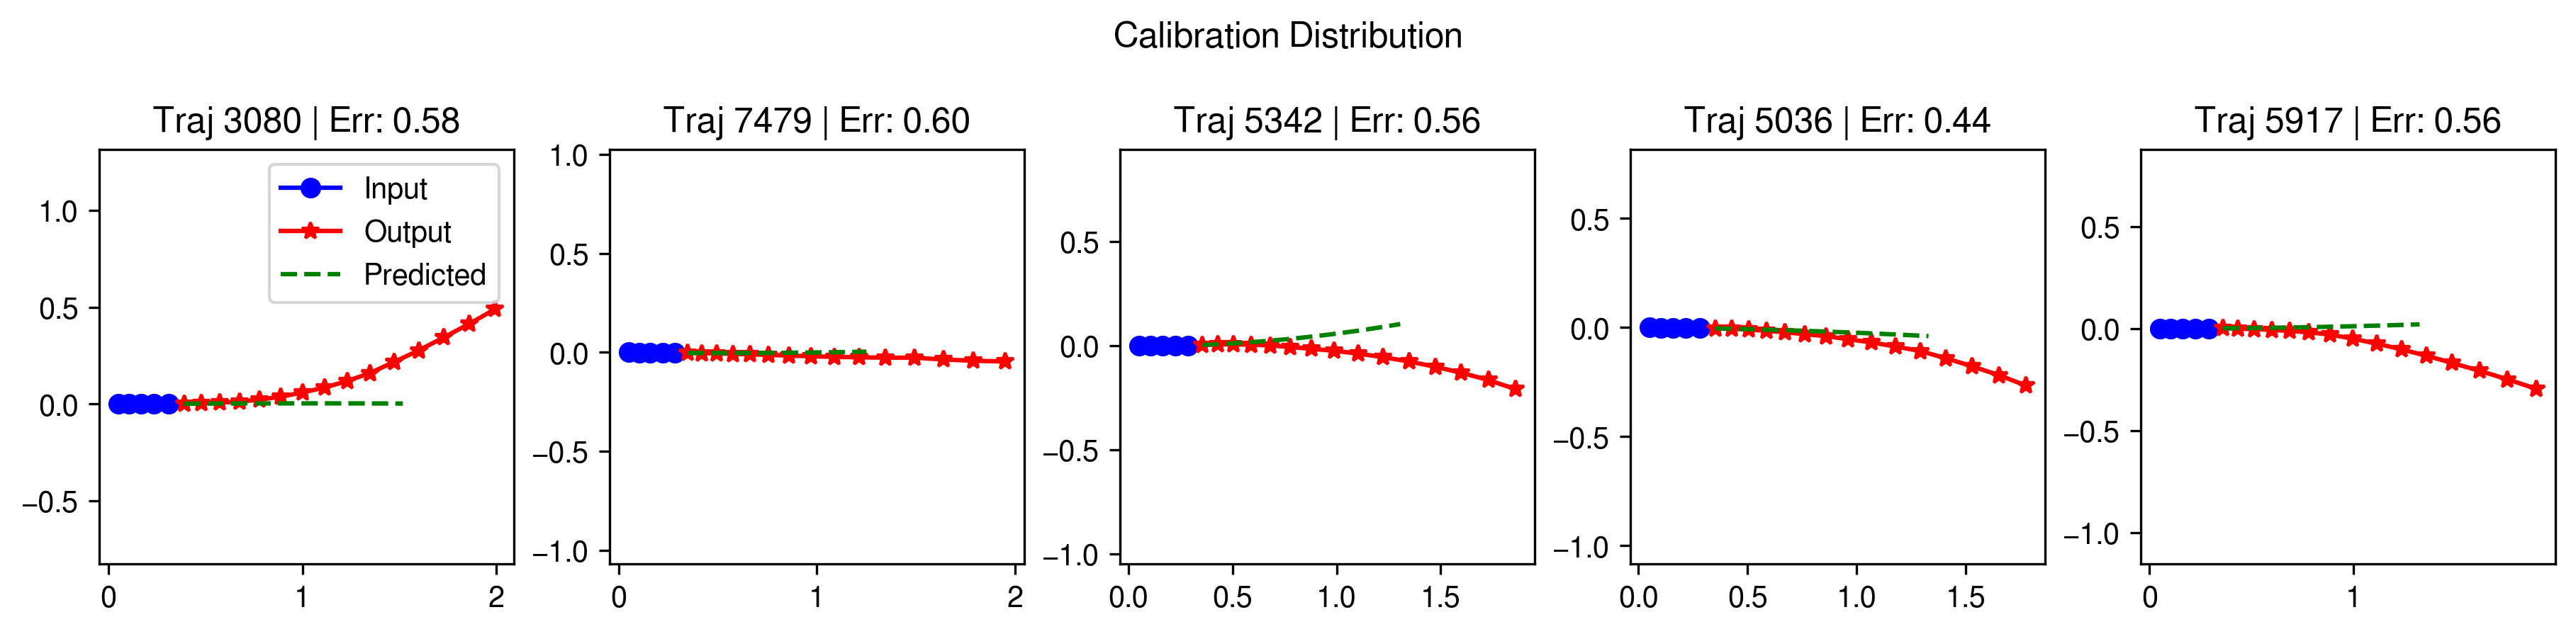

In [7]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [8]:
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,-1,:2] - env_Y_hat[:,-1,:2]
np.random.shuffle(Z_env)

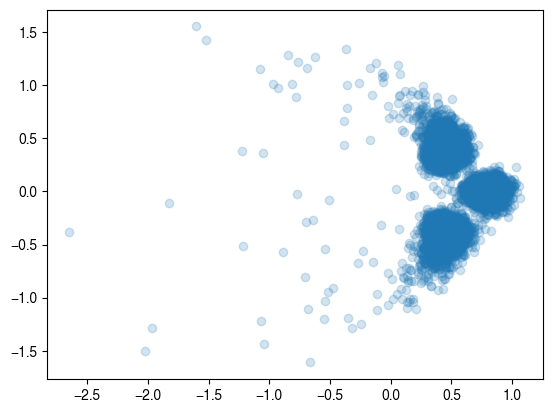

In [9]:
plt.scatter(Z_env[:,0], Z_env[:,1], alpha=0.2)

# Use Parametrized Conformal Regions for Prediction

In [10]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import HyperRectangle, ConvexHullTemplate, Ellipse
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [11]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 2) (3333, 2) (3334, 2)


## Convex Hull

In [12]:
DELTA = 0.90
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, ConvexHullTemplate, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)

Total Weight Sum: 0.9768877244566496


Test Coverage:  0.9067186562687463


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.91')

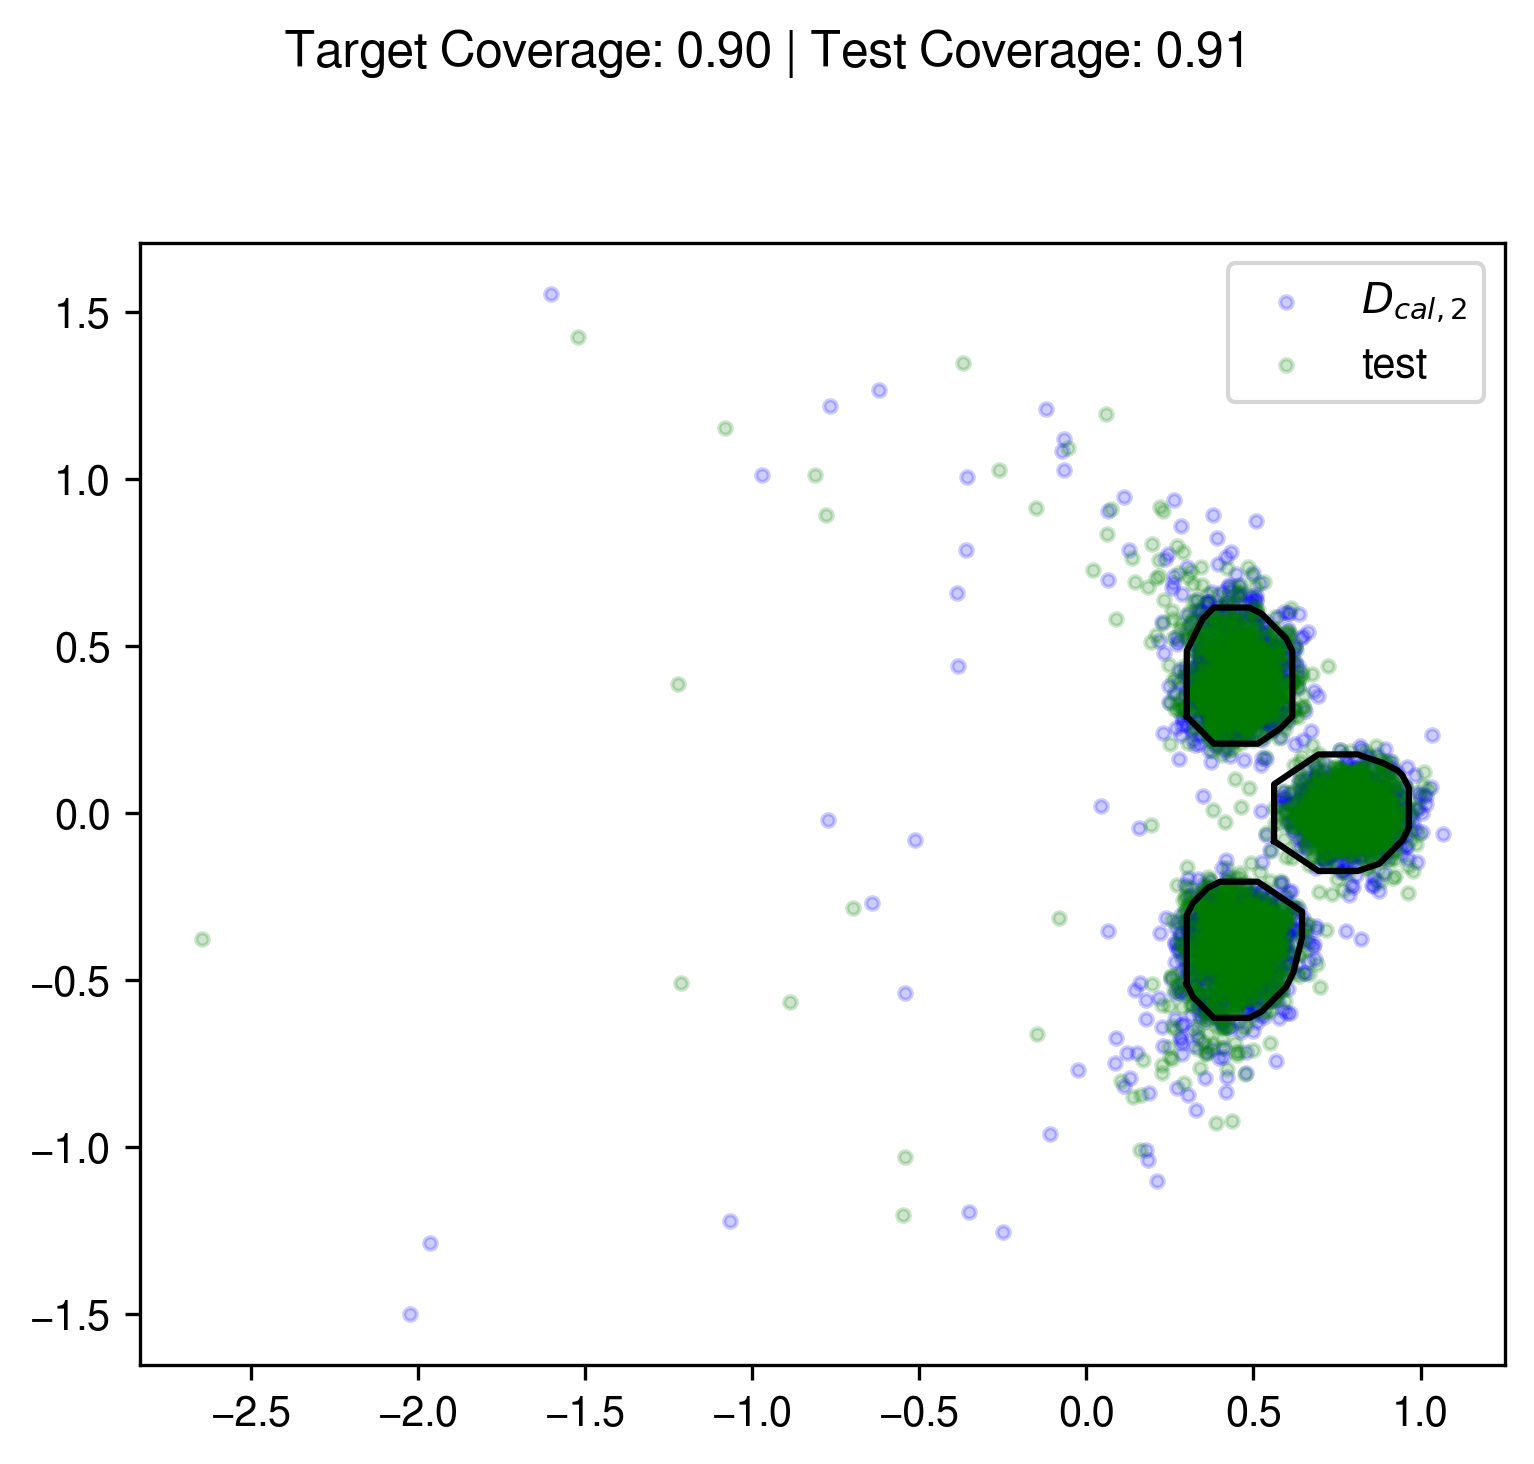

In [13]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Convex Hull Prediction Region for Endpoint')

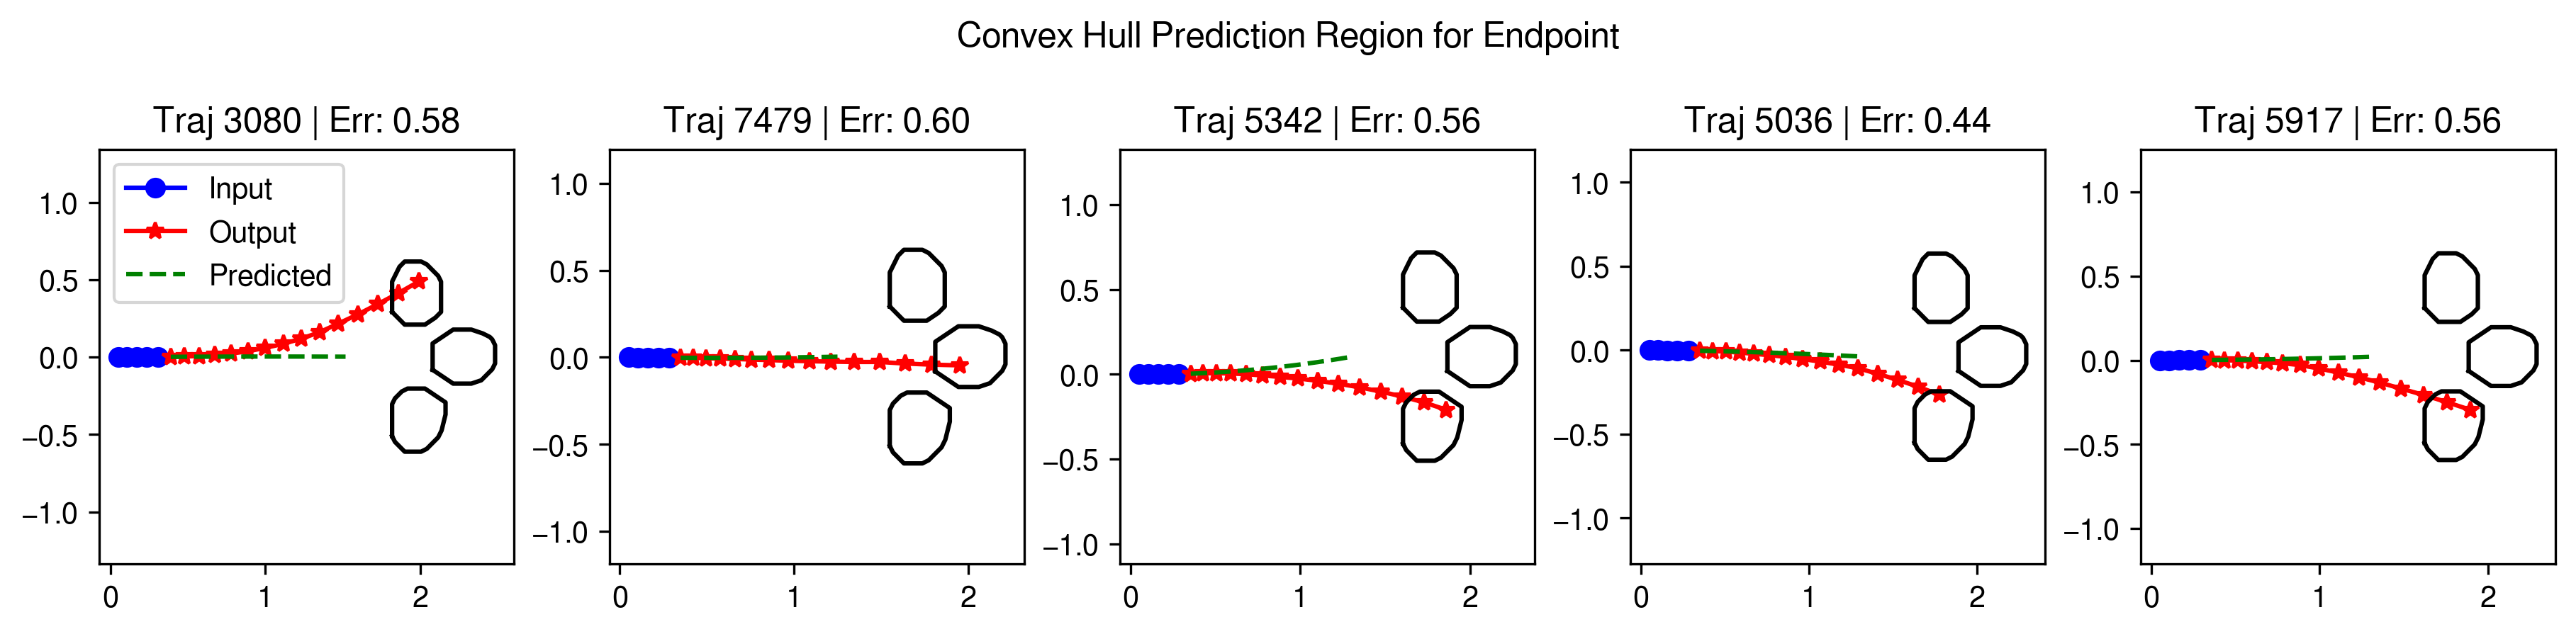

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

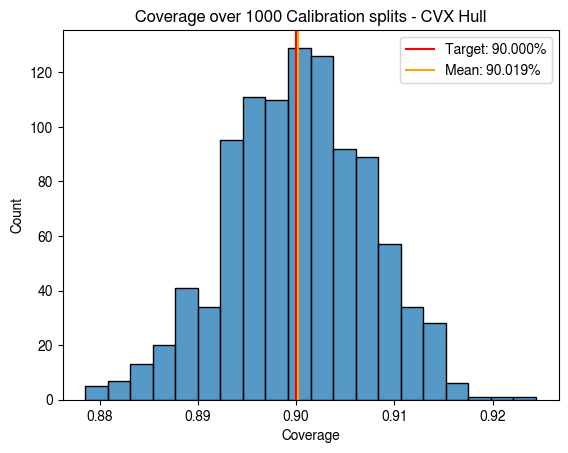

In [15]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [16]:
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, Ellipse, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
print(pcr.normalizing_constant)

Total Weight Sum: 0.9768877244566496
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=790975, Wed Nov 22 23:13:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.663875922288506e+00 1.0e+00 9.63e-01  9e-01  1e+00 0:00.0
    2     18 1.570656475762614e+00 1.2e+00 8.83e-01  8e-01  9e-01 0:00.0
    3     27 5.262331799885430e-01 1.2e+00 9.02e-01  8e-01  1e+00 0:00.0
  100    900 7.151707995599935e-02 1.6e+02 3.76e-03  6e-05  5e-03 0:01.5
  200   1800 7.150555719277041e-02 2.6e+03 4.10e-06  5e-09  5e-06 0:02.9
NOTE (module=cma, iteration=275):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 7.8e+08 to 4.1e+06
  291   2619 7.150555483383698e-02 2.9e+03 1.40e-08  1e-12  2e-08 0:04.2
termination on tolfun=1e-11 (Wed Nov 22 23:13:44 2023)
final/bestever f-value = 7.150555e-02 7.150555e-02 after 2620/2560 evaluations
incumbent solution: [1.3438169156493909, -2.6133822882146682, -2.180265835528964

/usr/local/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=286)
  warnings.warn(msg + ' (' +


    1      9 1.274665849053320e+00 1.0e+00 8.72e-01  8e-01  9e-01 0:00.0
    2     18 3.336889924786629e-01 1.1e+00 7.74e-01  7e-01  8e-01 0:00.0
    3     27 1.660453476023907e+00 1.3e+00 7.32e-01  6e-01  7e-01 0:00.0
  100    900 7.101465444484896e-02 8.3e+01 6.48e-03  2e-04  5e-03 0:01.4
  200   1800 7.094121583108788e-02 1.3e+03 1.50e-05  2e-08  1e-05 0:02.9
  300   2700 7.094120418556792e-02 2.1e+04 1.01e-08  1e-12  7e-09 0:04.3
termination on tolfun=1e-11 (Wed Nov 22 23:13:53 2023)
final/bestever f-value = 7.094120e-02 7.094120e-02 after 2701/2695 evaluations
incumbent solution: [2.1524031010766524, -0.698400420477125, 0.9675036515366191, 1.9532974489920267, 0.4486210777100279, 0.40240612085570604]
std deviation: [4.626164598580672e-09, 6.392175771558753e-09, 7.474850334679004e-09, 4.342093525248077e-09, 1.1025798855390984e-12, 1.2028541098307064e-12]
[array([[5.56890243, 0.38658318],
       [0.38658318, 4.30313407]])]
[array([0.44862108, 0.40240612])]
Soln time: 4.45633268356323

Test Coverage:  0.9043191361727655


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

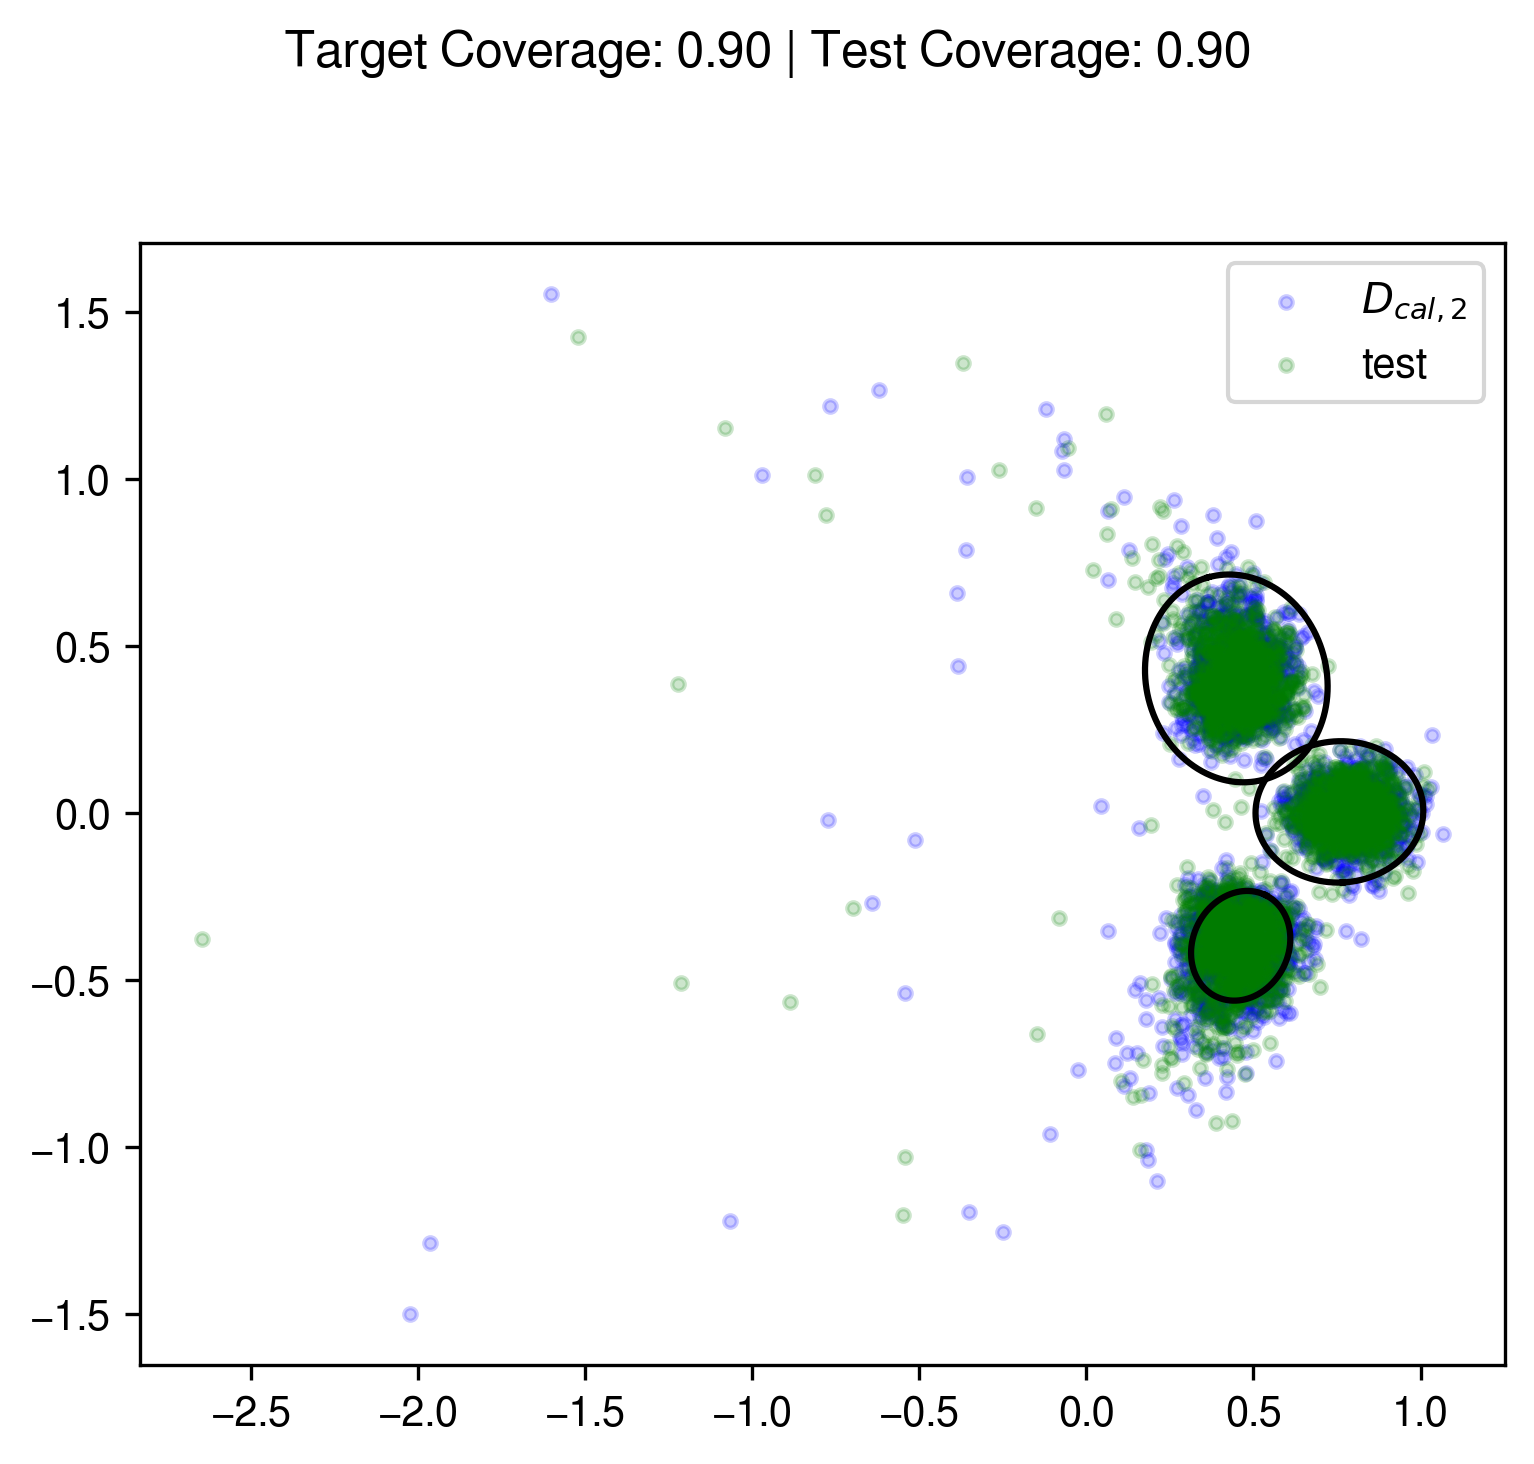

In [17]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Ellipsoid Prediction Region for Endpoint')

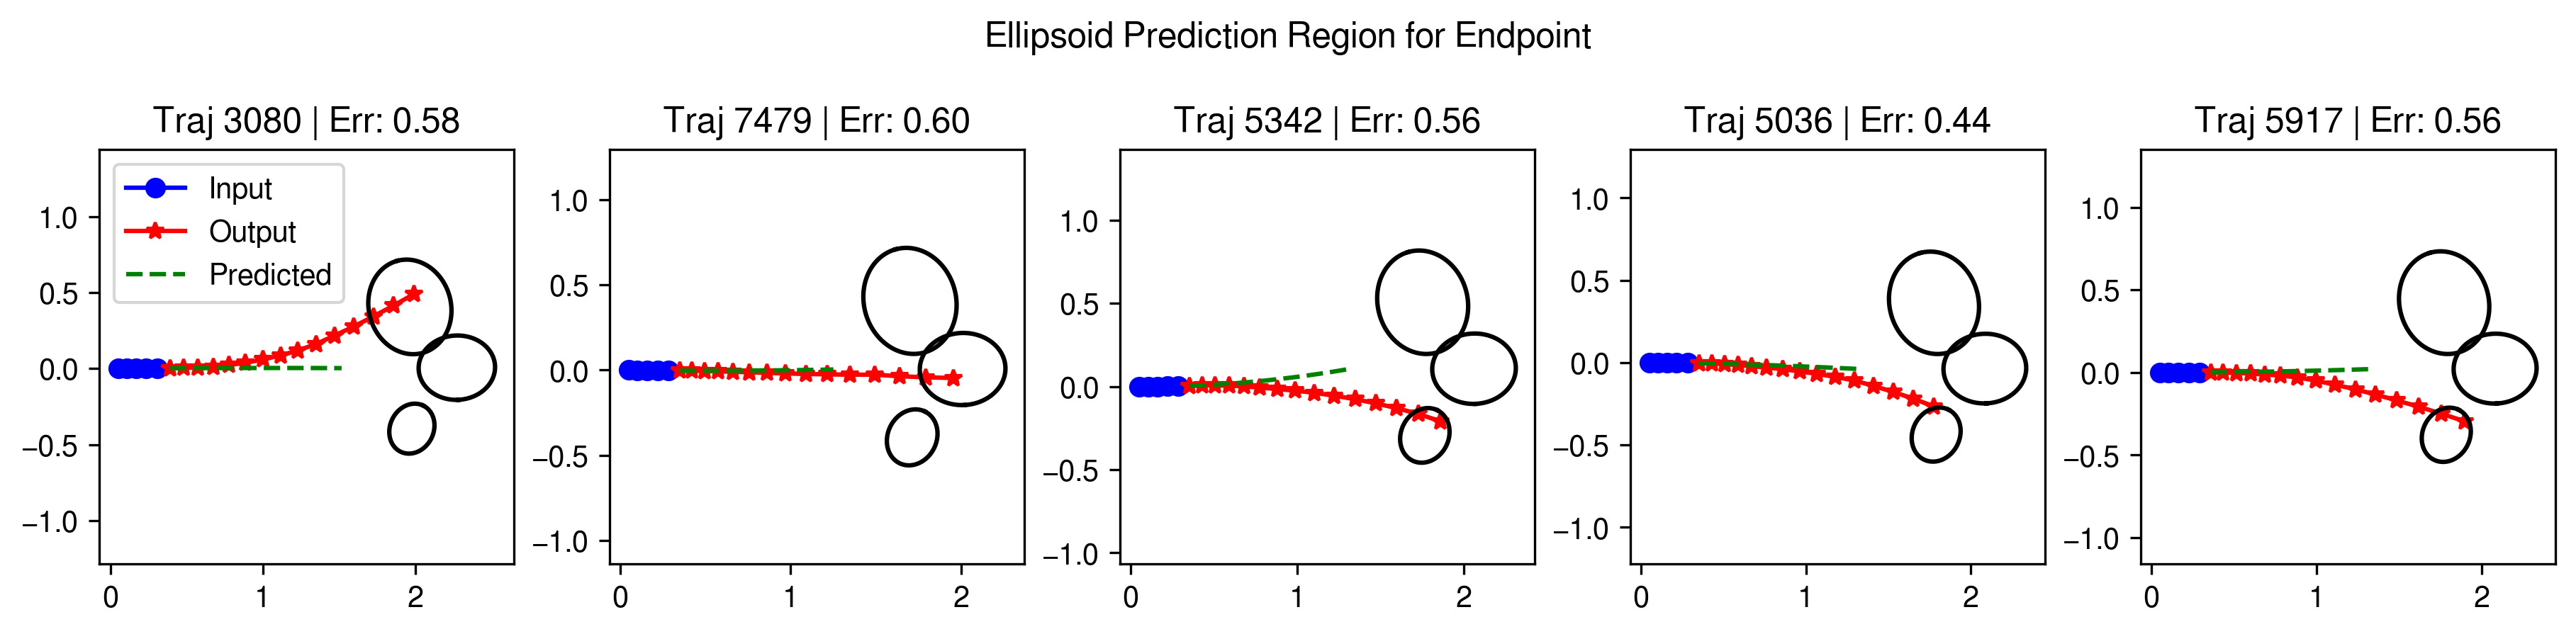

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

In [19]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

## Hyperrectangle

In [ ]:
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, HyperRectangle, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)

In [ ]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

In [ ]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()